In [2]:
import numpy as np
import torch

X_test = np.load("X_test_real.npy")
y_test = np.load("y_test_real.npy")

X_test_t = torch.tensor(X_test, dtype = torch.float32)
y_test_t = torch.tensor(y_test, dtype = torch.float32)

X_test_t.shape, y_test_t.shape

(torch.Size([866, 20, 4]), torch.Size([866]))

In [8]:
print("y_test contains NaN:", torch.isnan(y_test_t).any().item())
print("y_test contains Inf:", torch.isinf(y_test_t).any().item())

y_test contains NaN: False
y_test contains Inf: False


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CrisprCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.3)

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 20)
            x = F.relu(self.conv1(dummy))
            x = F.relu(self.conv2(x))
            x = F.max_pool1d(x, kernel_size=2)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrisprCNN().to(device)

model.load_state_dict(torch.load("crispr_cnn_real_day9.pth", map_location=device))
model.eval()

model

CrisprCNN(
  (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
# generating predictions on unseen CRISPR guides

with torch.no_grad():
  X_test_t = X_test_t.to(device)
  preds = model(X_test_t).cpu().numpy()

preds[:5], y_test[:5]

(array([0.47410777, 0.50058883, 0.52959573, 0.49848273, 0.46254984],
       dtype=float32),
 array([0.3317659 , 0.11715858, 0.07023512, 0.7164582 , 0.08334167],
       dtype=float32))

In [13]:
# computing evaluation metrics. Quantifying how well modl predicts real experimental outcomes

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

mse, mae, r2

(0.08299748599529266, 0.2511686682701111, 0.005789697170257568)

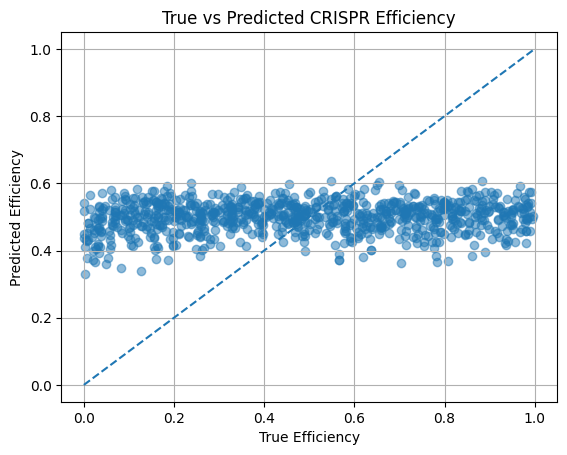

In [16]:
# true vs predicted visalization

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("True Efficiency")
plt.ylabel("Predicted Efficiency")
plt.title("True vs Predicted CRISPR Efficiency")
plt.grid(True)
plt.savefig("true_vs_predicted_day10.png")
plt.show()

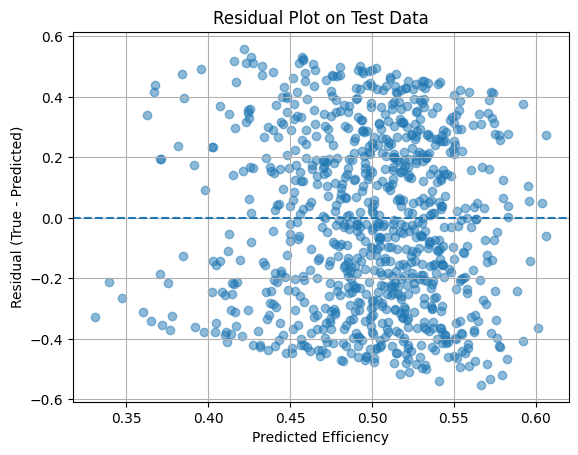

In [17]:
residuals = y_test - preds


plt.figure()
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Efficiency")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot on Test Data")
plt.grid(True)
plt.savefig("residuals_day10.png")
plt.show()